In [1]:
# References: https://www.kaggle.com/code/erikbruin/riiid-comprehensive-eda-baseline#2.-Baseline-model

# LGBM Model simple

In [9]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype


DATA_DIR = '../mlbd-2023/data/calcularis'

users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)


In [10]:
import lightgbm as lgb

## Create time series
- Create column "week_sequential" -> Normalize dates to start at 1 for every student
- Join events and subtasks on event_id. Ignore subtasks not tied to an event


In [11]:
events[['Year', 'Week', 'Day']] = pd.to_datetime(events['start']).dt.isocalendar()
events['year_week'] = ((events['Year'] - 2015) * 53 + events['Week']).astype(int)
ts = events.reset_index().groupby(['user_id','year_week'])['event_id'].count().reset_index()
ts.rename(columns={'event_id':'num_events'}, inplace=True)

In [12]:
print(len(set(events.reset_index().event_id.unique()) - set(subtasks.event_id.unique())))
print("Some events have no subtasks")
print(len(set(subtasks.event_id.unique()) - set(events.reset_index().event_id.unique())))
print("There are no subtasks which don't correspond to an event")
print("We don't care about subtasks which don't have a coresponding event_id because we don't know what skill they are for")

427
Some events have no subtasks
0
There are no subtasks which don't correspond to an event
We don't care about subtasks which don't have a coresponding event_id because we don't know what skill they are for


In [13]:
events_and_substasks = events.reset_index().merge(subtasks.reset_index(), how='left', on=['event_id','user_id'], suffixes=('_event', '_subtask'))
events_and_substasks['date'] = pd.to_datetime(events_and_substasks['start'])
events_and_substasks[['Year', 'Week', 'Day']] = events_and_substasks['date'].dt.isocalendar()
events_and_substasks['year_week'] = (events_and_substasks['Year'] - 2015) * 53 + events_and_substasks['Week']
events_and_substasks['week_sequential'] = events_and_substasks.groupby('user_id')['year_week'].apply(lambda x: x - x.iat[0])

In [14]:
task_events = events_and_substasks.query('type_event == "task" & correct != "nan"')

## Feature Selection
- Ignore categorical features with nulls for now

In [15]:
index = ['event_id','user_id']
cat_features = ['mode_event', 'game_name','number_range','skill_id', 'type_subtask']
cat_features_withnulls = [ 'destination', 'multiplier','operator','representation', 'solutionRepresentation', 'solveMode']
date_features = ['date','Year', 'Week', 'Day','week_sequential']
target_feature = ['correct']

In [16]:
df = task_events[index + cat_features + date_features + target_feature]

## Feature Engineering
- Create column "cumulative_percent_correct" - a feature for each student on their percentage correct so far (no data leakage from the future!)

In [17]:
df = df.sort_values(by='date')

In [18]:
# Create a feature that represents the student's overall cumulative accuracy per skill
cumulative_percent_correct = df.groupby(['user_id','skill_id'],sort=False)['correct'].expanding(1).mean().reset_index().drop(columns=['user_id','skill_id']).rename(columns={'correct':'cumulative_percent_correct'})

In [19]:
df = df.merge(cumulative_percent_correct, left_index=True, right_on='level_2', how='left')

In [20]:
# Create a feature that represents the student's accuracy over the last 30 days per skill
# window_size = 30
# df_roll = df.groupby(['user_id','skill_id'])['correct'].rolling(window_size).mean()

# Other ideas:
# Num Questions answered so far
# percent correct on skill type by all players so far

In [21]:
df

,event_id,user_id,mode_event,game_name,number_range,skill_id,type_subtask,date,Year,Week,Day,week_sequential,correct,level_2,cumulative_percent_correct
0,118,7,NORMAL,Subitizing,R10,1.0,ConciseTimeoutDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,True,135,1.000000
1,118,7,NORMAL,Subitizing,R10,1.0,ConciseSubitizingTaskDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,True,134,1.000000
2,119,7,NORMAL,Conversion,R10,3.0,ConciseConversionTaskDescription,2015-03-20 18:07:17.288000+00:00,2015,12,5,0,True,136,1.000000
3,120,7,NORMAL,Landing,R10,19.0,ConciseLandingTaskDescription,2015-03-23 15:18:26.515000+00:00,2015,13,1,1,True,137,1.000000
4,121,7,END_OF_NR,Conversion,R10,7.0,ConciseConversionTaskDescription,2015-04-02 14:03:06.836000+00:00,2015,14,4,2,True,138,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53429,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,True,36904,0.777778
53430,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,True,36903,0.789474
53431,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,True,36907,0.800000
54399,12966,318,END_OF_NR,Distance,R100,105.0,ConciseOrdinalityTaskDescription,2023-02-12 09:08:57.789000+00:00,2023,6,7,14,False,19918,0.000000


In [22]:
# Check there are no nans
df.isna().sum()

event_id                      0
user_id                       0
mode_event                    0
game_name                     0
number_range                  0
skill_id                      0
type_subtask                  0
date                          0
Year                          0
Week                          0
Day                           0
week_sequential               0
correct                       0
level_2                       0
cumulative_percent_correct    0
dtype: int64

In [23]:
# LGBM only accepts int, bool and float
for col in cat_features:
    # Convert categories into ints
    df[col] = df[col].astype('category')
df['week_sequential'] = df['week_sequential'].astype('int32')
df[target_feature] = df[target_feature].astype('bool')

## Create train / validation split
- Split on user id (model should be evaluated on students it has never seen before)
- More sophisticated splitting on larger dataset


In [24]:
generated_features = ['cumulative_percent_correct']
features = index + cat_features + generated_features + ['week_sequential']

train = df.query('user_id < 800')[features]
y_train = df.query('user_id < 800')[target_feature]

val = df.query('user_id > 800')[features]
y_val = df.query('user_id > 800')[target_feature]

In [ ]:
lgb_train = lgb.Dataset(train, y_train, categorical_feature = cat_features)
lgb_eval = lgb.Dataset(val, y_val, categorical_feature = cat_features)

## Build Model

In [25]:
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 0,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
          # 'num_leaves': 200,
          # 'feature_fraction': 0.75,
          # 'bagging_freq': 10,
          # 'bagging_fraction': 0.80
         }

In [27]:
%%time
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8
)

/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 35935, number of negative: 8595
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1215
[LightGBM] [Info] Number of data points in the train set: 44530, number of used features: 9


/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.806984 -> initscore=1.430531
[LightGBM] [Info] Start training from score 1.430531
Training until validation scores don't improve for 8 rounds
Early stopping, best iteration is:
[25]	training's auc: 0.978677	valid_1's auc: 0.977868
CPU times: user 22.2 s, sys: 253 ms, total: 22.4 s
Wall time: 13.6 s


## Evaluate Model
- Compare performance per skill
- Look at feature importances (try SHAP in future)

In [32]:
# TODO fix
model.eval(val, 'val')

TypeError: Can only eval for Dataset instance

In [30]:
# Compare performance per skill
val.query('skill_id == 0')

,event_id,user_id,mode_event,game_name,number_range,skill_id,type_subtask,cumulative_percent_correct,week_sequential
25831,31862,851,END_OF_NR,Estimation,R10,0.0,ConciseEstimationTaskDescription,1.000000,20
25832,31862,851,END_OF_NR,Estimation,R10,0.0,ConciseTimeoutDescription,1.000000,20
26326,35720,956,END_OF_NR,Conversion,R10,0.0,ConciseConversionTaskDescription,1.000000,18
28389,37392,998,NORMAL,Subitizing,R10,0.0,ConciseTimeoutDescription,1.000000,0
28390,37392,998,NORMAL,Subitizing,R10,0.0,ConciseSubitizingTaskDescription,1.000000,0
...,...,...,...,...,...,...,...,...,...
48067,36841,980,FREE_TRAINING,Comparison,R10,0.0,ConciseSetComparisonTaskDescription,0.928571,52
48068,36842,980,FREE_TRAINING,Comparison,R10,0.0,ConciseTimeoutDescription,0.933333,52
48069,36842,980,FREE_TRAINING,Comparison,R10,0.0,ConciseSetComparisonTaskDescription,0.937500,52
38652,30221,802,FREE_TRAINING,Comparison,R10,0.0,ConciseSetComparisonTaskDescription,0.923077,95


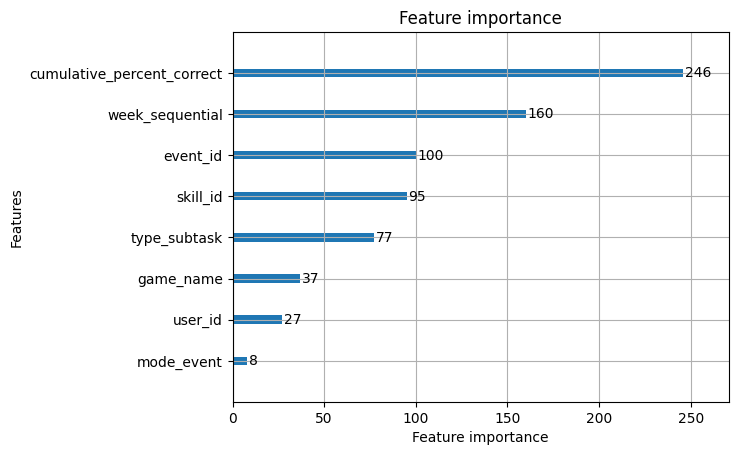

In [28]:
lgb.plot_importance(model)
plt.show()

In [37]:
# compute the split value histogram for the selected feature
hist, bin_edges = model.get_split_value_histogram('week_sequential', bins=50, xgboost_style=False)

# print the histogram and bin edges
print('Split value histogram for feature {}:'.format(0))
print('Bin edges:', bin_edges)
print('Histogram:', hist)

Split value histogram for feature 0:
Bin edges: [1.00000002e-35 3.55000000e+00 7.10000000e+00 1.06500000e+01
 1.42000000e+01 1.77500000e+01 2.13000000e+01 2.48500000e+01
 2.84000000e+01 3.19500000e+01 3.55000000e+01 3.90500000e+01
 4.26000000e+01 4.61500000e+01 4.97000000e+01 5.32500000e+01
 5.68000000e+01 6.03500000e+01 6.39000000e+01 6.74500000e+01
 7.10000000e+01 7.45500000e+01 7.81000000e+01 8.16500000e+01
 8.52000000e+01 8.87500000e+01 9.23000000e+01 9.58500000e+01
 9.94000000e+01 1.02950000e+02 1.06500000e+02 1.10050000e+02
 1.13600000e+02 1.17150000e+02 1.20700000e+02 1.24250000e+02
 1.27800000e+02 1.31350000e+02 1.34900000e+02 1.38450000e+02
 1.42000000e+02 1.45550000e+02 1.49100000e+02 1.52650000e+02
 1.56200000e+02 1.59750000e+02 1.63300000e+02 1.66850000e+02
 1.70400000e+02 1.73950000e+02 1.77500000e+02]
Histogram: [34 17 10  7  3  9  8  4  3  1  5  4  1  2  4  5  5  0  0  0  5  5  3  0
  0  2  0  1  2  3  0  0  0  1  2  3  1  0  0  1  2  0  2  0  1  0  2  1
  0  1]


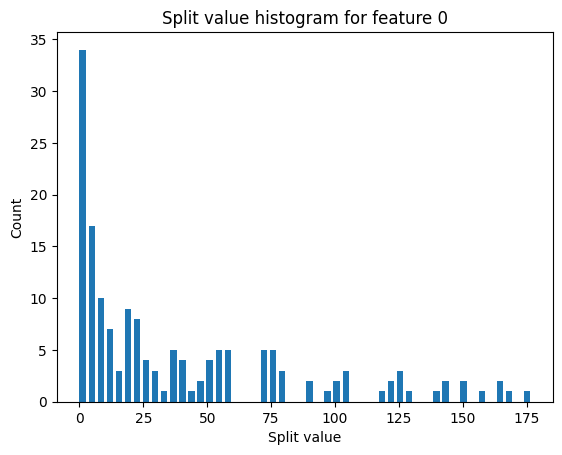

In [38]:
# plot the histogram
plt.bar(bin_edges[:-1], hist, width=(bin_edges[1]-bin_edges[0])*0.7, align='edge')

# add labels and title
plt.xlabel('Split value')
plt.ylabel('Count')
plt.title('Split value histogram for feature {}'.format(0))

# display the plot
plt.show()

In [40]:
# Notes
# Split on students never seen before
# Train on all, evaluate on one skill at a time (why does the model perform bettwe for certain skills)
# Categorical features -> one hot might be more explainable
    # Performance is typically better with integer encoding
# Plot each skill forecast ?
# LSTM (watch lecture), Transformer (need lots of data)